In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import requests
import zipfile
import io
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from meteostat import Daily, Stations
from datetime import datetime

## Temperature

In [16]:
# Get Portuguese weather stations
stations = Stations().region('PT').fetch()  # Fetches 10 stations in Portugal
stations.head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
08000,Água de Pena,PT,MA,08000,LPMA,32.7000,-16.7700,60.0,Atlantic/Madeira,2004-05-10,2025-03-02,2004-05-11,2022-04-25,2008-01-01,2022-01-01
08501,Flores Acores,PT,AZ,08501,LPFL,39.4500,-31.1333,28.0,Atlantic/Azores,1978-12-01,2025-03-02,1978-12-01,2025-02-24,1980-01-01,2022-01-01
08502,Corvo Acores,PT,AZ,08502,LPCR,39.6667,-31.1167,18.0,Europe/Lisbon,2003-10-23,2024-11-13,2021-06-03,2022-03-25,NaT,NaT
08505,Horta / Castelo Branco Acores,PT,AZ,08505,LPHR,38.5167,-28.7167,40.0,Atlantic/Azores,1976-02-01,2025-03-02,1999-01-02,2022-04-24,2020-01-01,2022-01-01
08506,Horta Acores,PT,AZ,08506,<NA>,38.5167,-28.6333,60.0,Atlantic/Azores,NaT,NaT,1973-01-01,2024-10-14,1949-01-01,2021-01-01


In [128]:
# Only keep weather stations that have daily data from 2012-01-01 to 2015-01-01
start_date = datetime(2012, 1, 1)
end_date = datetime(2015, 1, 1)
start_date_mask = stations['daily_start'] <= start_date
end_date_mask = stations['daily_end'] >= end_date

stations_mask = start_date_mask & end_date_mask
selected_stations = stations[stations_mask]
station_ids = list(selected_stations.index.unique())

print(f'Found {len(station_ids)} stations.')

Found 24 stations.


In [132]:
selected_stations['region'].value_counts()

region
AZ    6
MD    3
LI    2
PO    2
MA    1
SE    1
LE    1
CO    1
FA    1
EV    1
BJ    1
VR    1
CB    1
BN    1
AV    1
Name: count, dtype: Int64

In [138]:
selected_stations['timezone'].value_counts()

timezone
Europe/Lisbon       13
Atlantic/Azores      6
Atlantic/Madeira     4
Europe/Madrid        1
Name: count, dtype: Int64

In [139]:
selected_stations[['region', 'timezone']].value_counts()

region  timezone        
AZ      Atlantic/Azores     6
MD      Atlantic/Madeira    3
LI      Europe/Lisbon       2
PO      Europe/Lisbon       2
AV      Europe/Lisbon       1
BJ      Europe/Lisbon       1
BN      Europe/Lisbon       1
CB      Europe/Lisbon       1
CO      Europe/Madrid       1
EV      Europe/Lisbon       1
FA      Europe/Lisbon       1
LE      Europe/Lisbon       1
MA      Atlantic/Madeira    1
SE      Europe/Lisbon       1
VR      Europe/Lisbon       1
Name: count, dtype: int64

In [130]:
station_data = Daily(station_ids, start=start_date, end=end_date).fetch()
station_data.head()

tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
station time                                                                  
08000   2012-01-01  16.1  14.0  18.0   NaN   NaN   NaN   6.6   NaN   NaN   NaN
        2012-01-02  16.8  15.0  19.0   NaN   NaN  15.0  13.2   NaN   NaN   NaN
        2012-01-03  17.4  16.0  19.0   NaN   NaN  22.0  11.9   NaN   NaN   NaN
        2012-01-04  17.6  17.0  19.0   NaN   NaN  32.0  18.0   NaN   NaN   NaN
        2012-01-05  17.6  16.0  20.0   NaN   NaN  28.0  15.6   NaN   NaN   NaN

In [133]:
station_regions = selected_stations['region'].reset_index()

station_avg_temperature = station_data['tavg'].reset_index().rename(columns={'station': 'id'})

average_daily_temperature_by_state_df = station_avg_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tavg'].mean()
average_daily_temperature_by_state_df = average_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tavg')

station_min_temperature = station_data['tmin'].reset_index().rename(columns={'station': 'id'})

minimum_daily_temperature_by_state_df = station_min_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tmin'].mean()
minimum_daily_temperature_by_state_df = minimum_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tmin')

station_max_temperature = station_data['tmax'].reset_index().rename(columns={'station': 'id'})

maximum_daily_temperature_by_state_df = station_max_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tmax'].mean()
maximum_daily_temperature_by_state_df = maximum_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tmax')

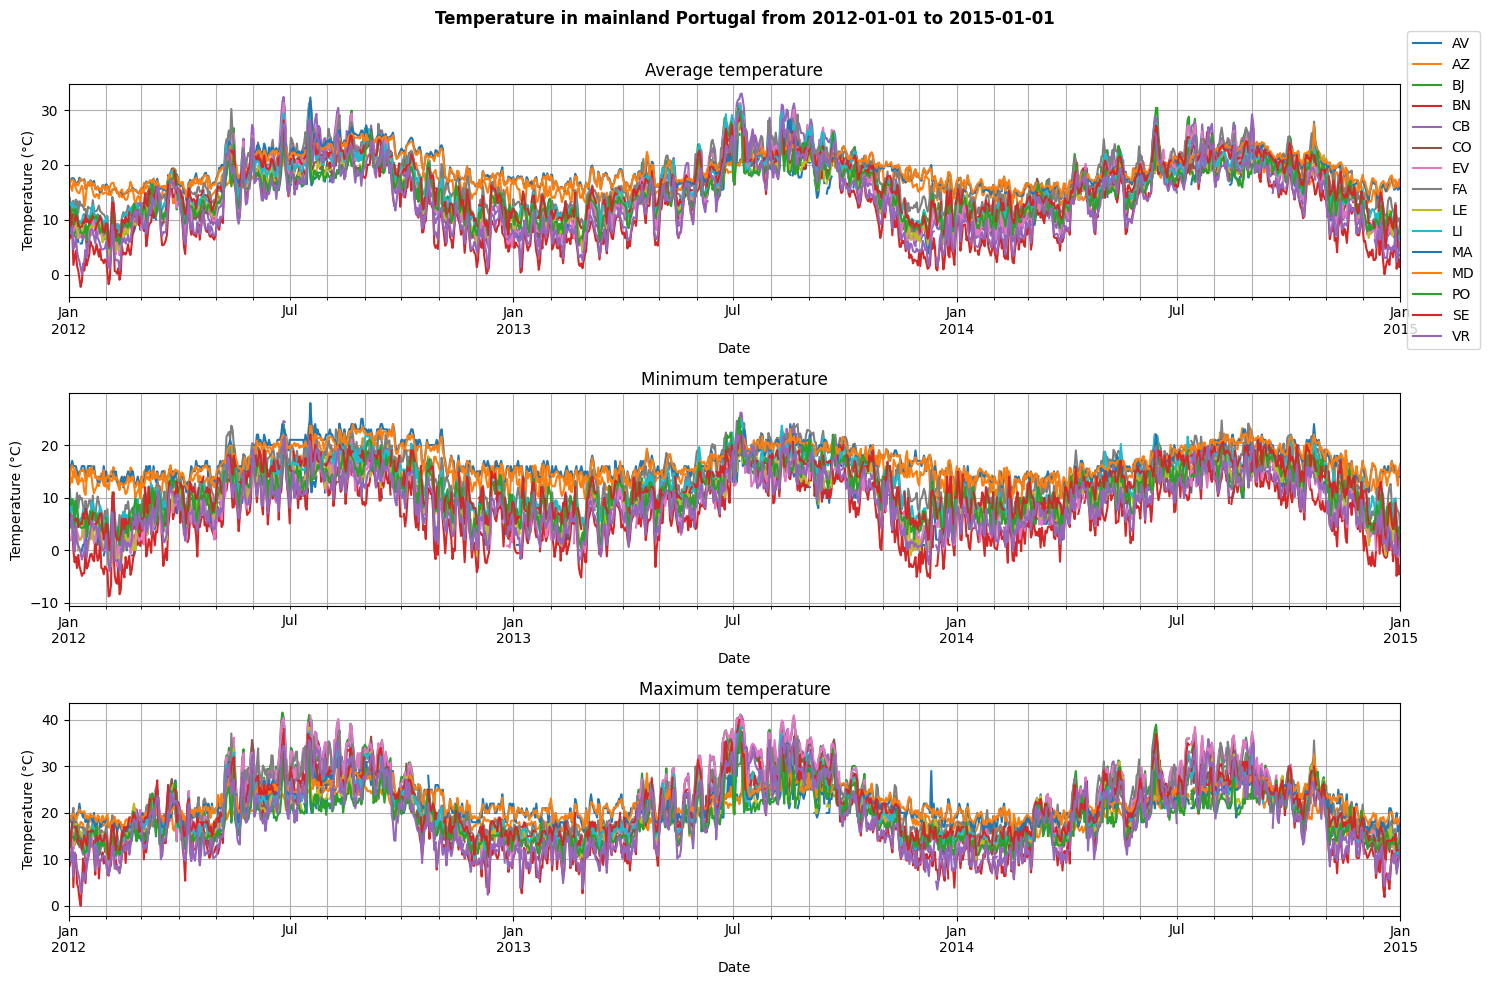

In [137]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

fig.suptitle('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

data = [
    ('Average temperature', average_daily_temperature_by_state_df),
    ('Minimum temperature', minimum_daily_temperature_by_state_df),
    ('Maximum temperature', maximum_daily_temperature_by_state_df),
]

first = True

for ax, (title, df) in zip(axs, data):
    df.plot(ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, which='both')
    if first:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        first = False
    else:
        ax.legend().remove()

plt.tight_layout()
plt.show()

In [140]:
# Find the weather stations that are not in Madeira (MA) or Azores (AZ).
# There two are islands in the atlantic and so can have very
# different weather from mainland Portugal. We assume that most
# of the data comes from mainland Portugal.
region_mask = ~stations['region'].isin(['AZ', 'MA', 'MD'])

# Only keep weather stations that have daily data from 2012-01-01 to 2015-01-01
start_date = datetime(2012, 1, 1)
end_date = datetime(2015, 1, 1)
start_date_mask = stations['daily_start'] <= start_date
end_date_mask = stations['daily_end'] >= end_date

stations_mask = region_mask & start_date_mask & end_date_mask
selected_stations = stations[stations_mask]
station_ids = list(selected_stations.index.unique())

print(f'Found {len(station_ids)} stations.')

Found 14 stations.


In [141]:
selected_stations['region'].value_counts()

region
LI    2
PO    2
SE    1
LE    1
CO    1
FA    1
EV    1
BJ    1
VR    1
CB    1
BN    1
AV    1
Name: count, dtype: Int64

In [142]:
station_data = Daily(station_ids, start=start_date, end=end_date).fetch()
station_data.head()

tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
station time                                                                  
08534   2012-01-01  10.9   6.0  16.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN
        2012-01-02  12.3   7.0  16.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN
        2012-01-03   8.4   4.8  14.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN
        2012-01-04  11.0   6.0  18.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN
        2012-01-06   9.9   5.8  17.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [143]:
station_regions = selected_stations['region'].reset_index()

station_avg_temperature = station_data['tavg'].reset_index().rename(columns={'station': 'id'})

average_daily_temperature_by_state_df = station_avg_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tavg'].mean()
average_daily_temperature_by_state_df = average_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tavg')

station_min_temperature = station_data['tmin'].reset_index().rename(columns={'station': 'id'})

minimum_daily_temperature_by_state_df = station_min_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tmin'].mean()
minimum_daily_temperature_by_state_df = minimum_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tmin')

station_max_temperature = station_data['tmax'].reset_index().rename(columns={'station': 'id'})

maximum_daily_temperature_by_state_df = station_max_temperature.merge(station_regions, on='id', how='left').groupby(['region', 'time'])['tmax'].mean()
maximum_daily_temperature_by_state_df = maximum_daily_temperature_by_state_df.reset_index().pivot_table(index='time', columns='region', values='tmax')

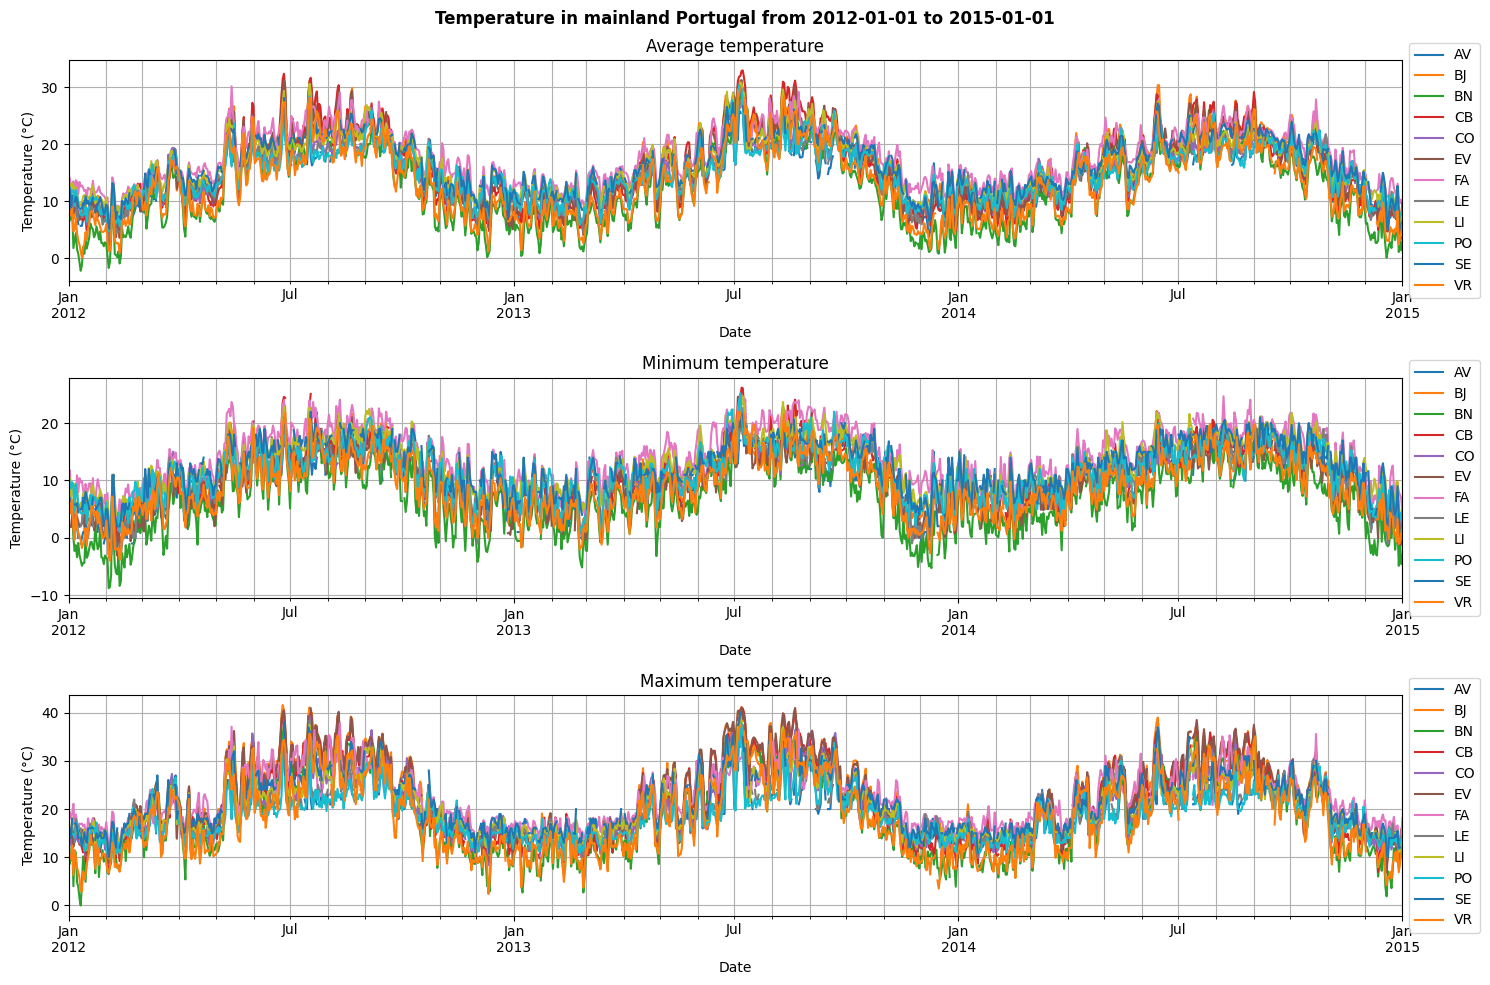

In [144]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

fig.suptitle('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

data = [
    ('Average temperature', average_daily_temperature_by_state_df),
    ('Minimum temperature', minimum_daily_temperature_by_state_df),
    ('Maximum temperature', maximum_daily_temperature_by_state_df),
]

for ax, (title, df) in zip(axs, data):
    df.plot(ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, which='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [145]:
temperature_avg_stats_df = station_data['tavg'].reset_index().groupby(by='time')['tavg'].agg([
    ('mean', np.mean),
    ('min', np.min),
    ('p10', lambda x: x.quantile(0.10)),
    ('p25', lambda x: x.quantile(0.25)),
    ('p50', lambda x: x.quantile(0.50)),
    ('p75', lambda x: x.quantile(0.75)),
    ('p90', lambda x: x.quantile(0.90)),
    ('max', np.max),
]).round(1)

temperature_min_stats_df = station_data['tmin'].reset_index().groupby(by='time')['tmin'].agg([
    ('mean', np.mean),
    ('min', np.min),
    ('p10', lambda x: x.quantile(0.10)),
    ('p25', lambda x: x.quantile(0.25)),
    ('p50', lambda x: x.quantile(0.50)),
    ('p75', lambda x: x.quantile(0.75)),
    ('p90', lambda x: x.quantile(0.90)),
    ('max', np.max),
]).round(1)

temperature_max_stats_df = station_data['tmax'].reset_index().groupby(by='time')['tmax'].agg([
    ('mean', np.mean),
    ('min', np.min),
    ('p10', lambda x: x.quantile(0.10)),
    ('p25', lambda x: x.quantile(0.25)),
    ('p50', lambda x: x.quantile(0.50)),
    ('p75', lambda x: x.quantile(0.75)),
    ('p90', lambda x: x.quantile(0.90)),
    ('max', np.max),
]).round(1)

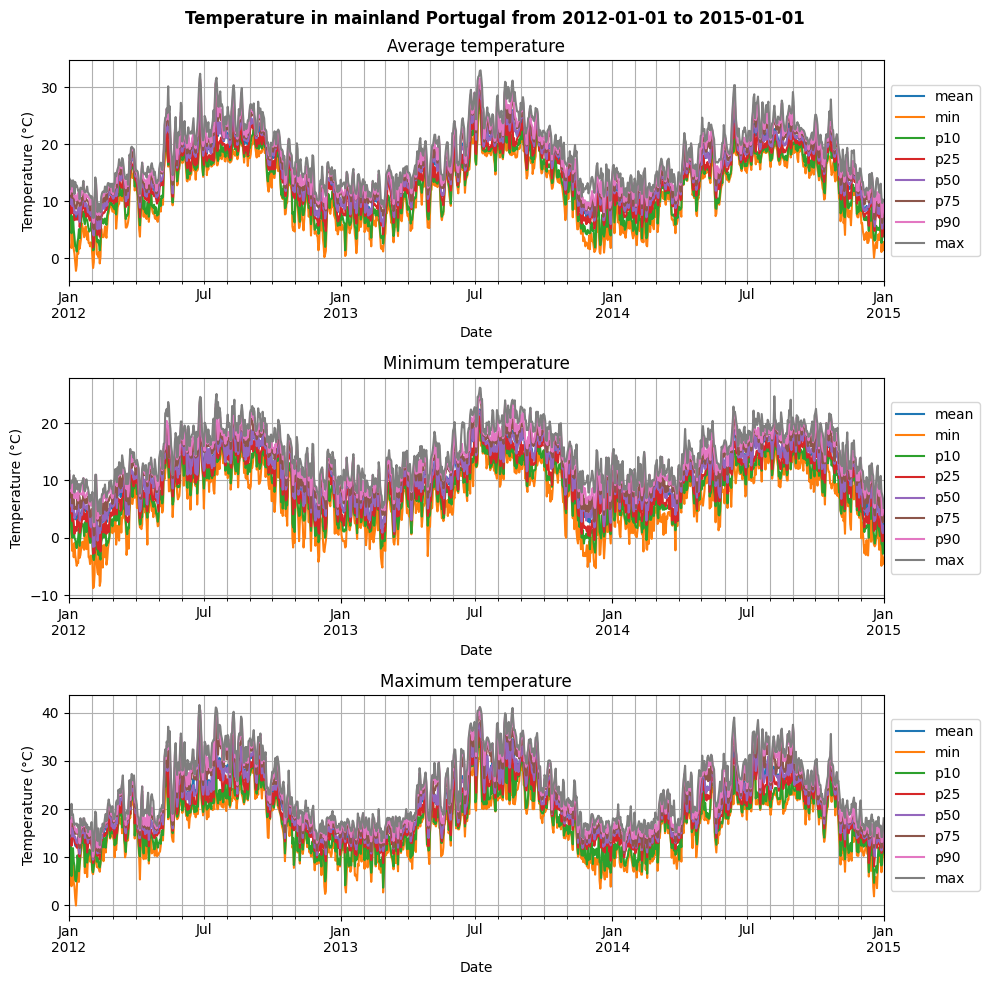

In [146]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

fig.suptitle('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

data = [
    ('Average temperature', temperature_avg_stats_df),
    ('Minimum temperature', temperature_min_stats_df),
    ('Maximum temperature', temperature_max_stats_df),
]

for ax, (title, df) in zip(axs, data):
    df.plot(ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, which='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

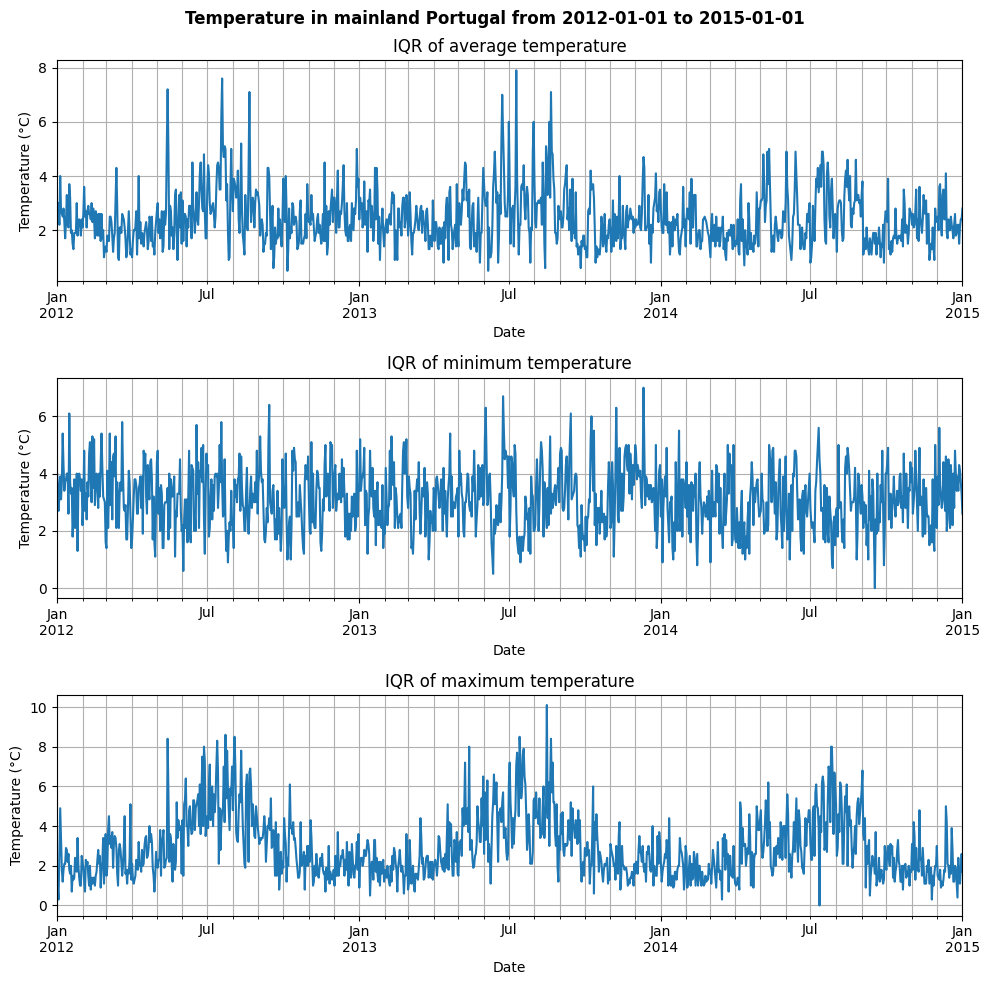

In [147]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

fig.suptitle('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

data = [
    ('IQR of average temperature', temperature_avg_stats_df['p75'] - temperature_avg_stats_df['p25']),
    ('IQR of minimum temperature', temperature_min_stats_df['p75'] - temperature_min_stats_df['p25']),
    ('IQR of maximum temperature', temperature_max_stats_df['p75'] - temperature_max_stats_df['p25']),
]

for ax, (title, df) in zip(axs, data):
    df.plot(ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [148]:
daily_temperature_variation_df = station_data['tmax'] - station_data['tmin']

daily_temperature_variation_statistics_df = daily_temperature_variation_df.groupby('time').agg([
    ('mean', np.mean),
    ('min', np.min),
    ('p10', lambda x: x.quantile(0.10)),
    ('p25', lambda x: x.quantile(0.25)),
    ('p50', lambda x: x.quantile(0.50)),
    ('p75', lambda x: x.quantile(0.75)),
    ('p90', lambda x: x.quantile(0.90)),
    ('max', np.max),
]).round(1)

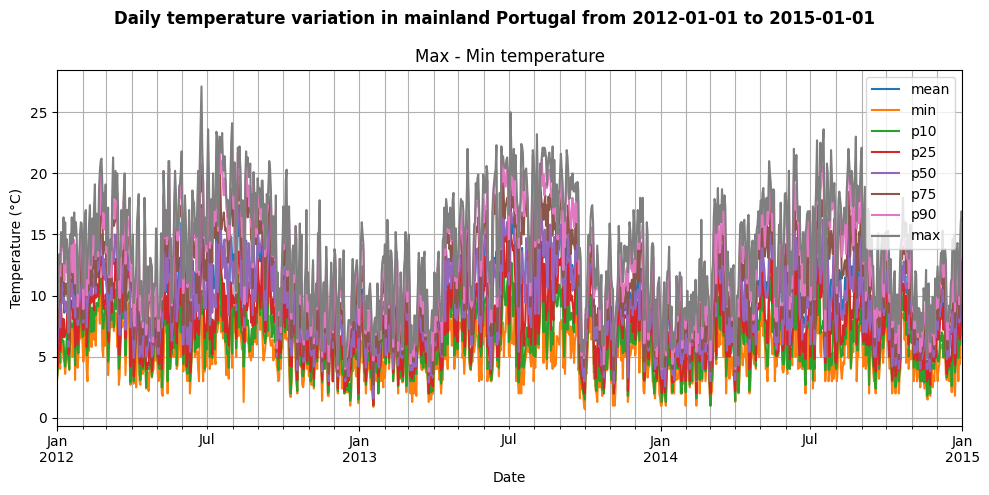

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

fig.suptitle('Daily temperature variation in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

daily_temperature_variation_statistics_df.plot(ax=ax)

ax.set_title('Max - Min temperature')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [189]:
# Define population data
population_data = {
    "LI": 2275385,
    "PO": 1785405,
    "SE": 874806,
    "BN": 846293,
    "AV": 700787,
    "FA": 467343,
    "LE": 458605,
    "CO": 408551,
    "VR": 185695,
    "CB": 177962,
    "EV": 152444,
    "BJ": 144401,
}

population_by_region = pd.Series(population_data).rename_axis('region')
population_percentages_by_region = population_by_region / population_by_region.sum()
population_percentages_by_region = population_percentages_by_region.rename('Population %')

population_percentages_by_region

region
LI    0.268397
PO    0.210601
SE    0.103189
BN    0.099826
AV    0.082663
FA    0.055126
LE    0.054096
CO    0.048191
VR    0.021904
CB    0.020992
EV    0.017982
BJ    0.017033
Name: Population %, dtype: float64

In [209]:
def calculate_weighted_average_by_population(station_metric: pd.Series, station_regions: pd.Series, weights: pd.Series):
    metric_name = station_metric.name
    weights_name = weights.name
    average_df = station_metric.reset_index().merge(station_regions.reset_index(), on='station', how='left')
    average_df = average_df.groupby(['time', 'region'])[metric_name].mean().reset_index()
    average_df = average_df.merge(weights.reset_index(), on='region', how='left')[['time', weights_name, metric_name]]
    average_df = average_df.groupby('time').apply(
        lambda group: (group[metric_name] * group[weights_name]).sum() / group[weights_name].sum(),
        include_groups=False
    ).rename(metric_name)
    return average_df


station_regions = selected_stations['region'].rename_axis('station')

station_avg_temperature = station_data['tavg']
station_min_temperature = station_data['tmin']
station_max_temperature = station_data['tmax']

tavg = calculate_weighted_average_by_population(station_avg_temperature, station_regions, population_percentages_by_region)
tmin = calculate_weighted_average_by_population(station_min_temperature, station_regions, population_percentages_by_region)
tmax = calculate_weighted_average_by_population(station_max_temperature, station_regions, population_percentages_by_region)

temperatures_df = pd.concat([tavg, tmin, tmax], axis=1).sort_index()
temperatures_df

,tavg,tmin,tmax
time,,,
2012-01-01,11.610813,8.636912,14.205970
2012-01-02,11.826729,7.981635,14.698529
2012-01-03,9.923062,6.096744,13.947590
2012-01-04,11.448423,6.855606,16.473857
2012-01-05,10.452590,6.860068,14.264390
...,...,...,...
2014-12-28,11.043963,6.391239,14.212960
2014-12-29,6.826169,2.817426,11.340169
2014-12-30,5.777150,1.907561,11.959080


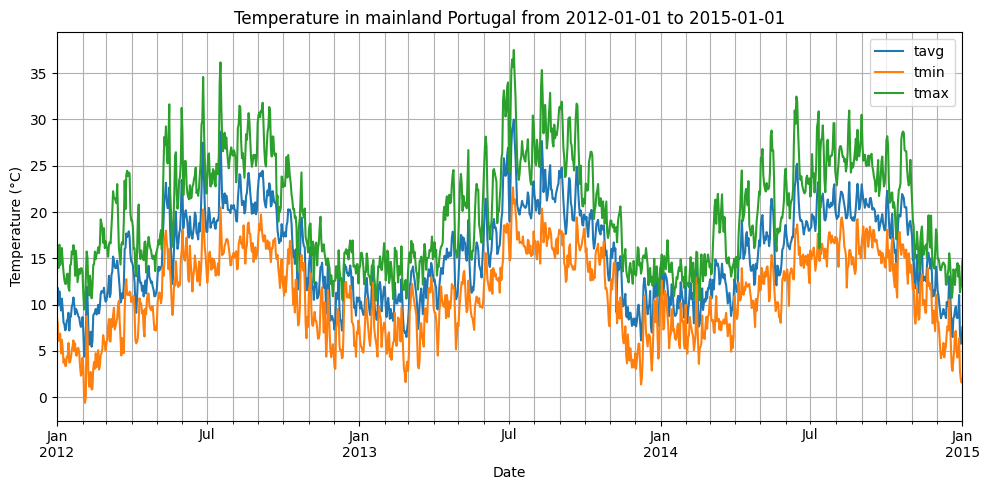

In [210]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

temperatures_df.plot(ax=ax)

ax.set_title('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [212]:
save_path = 'dataset/temperature/temperature.parquet'

temperatures_df.T.to_parquet(save_path)

saved_tempereatures_df = pd.read_parquet(save_path)
saved_tempereatures_df.head()

time,2012-01-01,2012-01-02,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-07,2012-01-08,2012-01-09,2012-01-10,...,2014-12-23,2014-12-24,2014-12-25,2014-12-26,2014-12-27,2014-12-28,2014-12-29,2014-12-30,2014-12-31,2015-01-01
tavg,11.610813,11.826729,9.923062,11.448423,10.452590,9.370619,10.655296,9.546486,8.055688,7.919485,...,9.411320,9.814192,8.613136,8.547396,8.835630,11.043963,6.826169,5.777150,6.140193,7.572890
tmin,8.636912,7.981635,6.096744,6.855606,6.860068,4.742796,6.210871,5.310825,3.743873,4.146206,...,6.979739,7.171860,4.920404,4.290951,4.894091,6.391239,2.817426,1.907561,1.577487,1.976903
tmax,14.205970,14.698529,13.947590,16.473857,14.264390,14.924038,16.116318,14.652431,13.514865,12.679808,...,12.124420,13.797697,13.786154,14.490178,13.040645,14.212960,11.340169,11.959080,12.757692,14.783953


## Public holidays

In [20]:
# Dataset proposed by this paper: https://shorturl.at/P8Mcs
HOLIDAYS_URL = 'https://data.worldpop.org/GIS/Holiday_Data/public_holidays/public_holidays_2010_2019.zip'

response = requests.get(HOLIDAYS_URL)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Assuming there's only one CSV file
    with zip_ref.open(csv_filename) as file:
        holidays_df = pd.read_csv(file)

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], format='%d/%m/%Y')

holidays_df.head()

,ADM_name,ISO3,Date,Name,Type
0,Aruba,ABW,2010-01-01,New Year's Day,Public holiday
1,Aruba,ABW,2010-01-25,Betico Croes' Birthday,Public holiday
2,Aruba,ABW,2010-02-15,Carnival Monday,Public holiday
3,Aruba,ABW,2010-03-18,National Anthem and Flag Day,Public holiday
4,Aruba,ABW,2010-04-02,Good Friday,Public holiday


In [15]:
holidays_df.query("ADM_name == 'Portugal'")['Type'].value_counts()

Type
Public holiday    108
Observance         51
Name: count, dtype: int64

In [30]:
portugal_mask = holidays_df['ADM_name'] == 'Portugal'
start_date_mask = holidays_df['Date'] >= pd.to_datetime('2012-01-01')
end_date_mask = holidays_df['Date'] <= pd.to_datetime('2015-01-01')
public_holidays_mask = holidays_df['Type'] == 'Public holiday'

portuguese_holidays = holidays_df[portugal_mask & start_date_mask & end_date_mask & public_holidays_mask][['Date', 'Name']].set_index('Date')['Name']
portuguese_holidays

Date
2012-04-06                           Good Friday
2012-04-08                         Easter Sunday
2012-04-25                           Liberty Day
2012-05-01                   Labor Day / May Day
2012-06-07                        Corpus Christi
2012-06-10                          Portugal Day
2012-08-15                    Assumption of Mary
2012-10-05                 Republic Implantation
2012-11-01                       All Saints' Day
2012-12-01           Restoration of Independence
2012-12-08    Feast of the Immaculate Conception
2012-12-25                         Christmas Day
2013-03-29                           Good Friday
2013-03-31                         Easter Sunday
2013-04-25                           Liberty Day
2013-05-01                   Labor Day / May Day
2013-06-10                          Portugal Day
2013-08-15                    Assumption of Mary
2013-12-08    Feast of the Immaculate Conception
2013-12-25                         Christmas Day
2014-04-18     

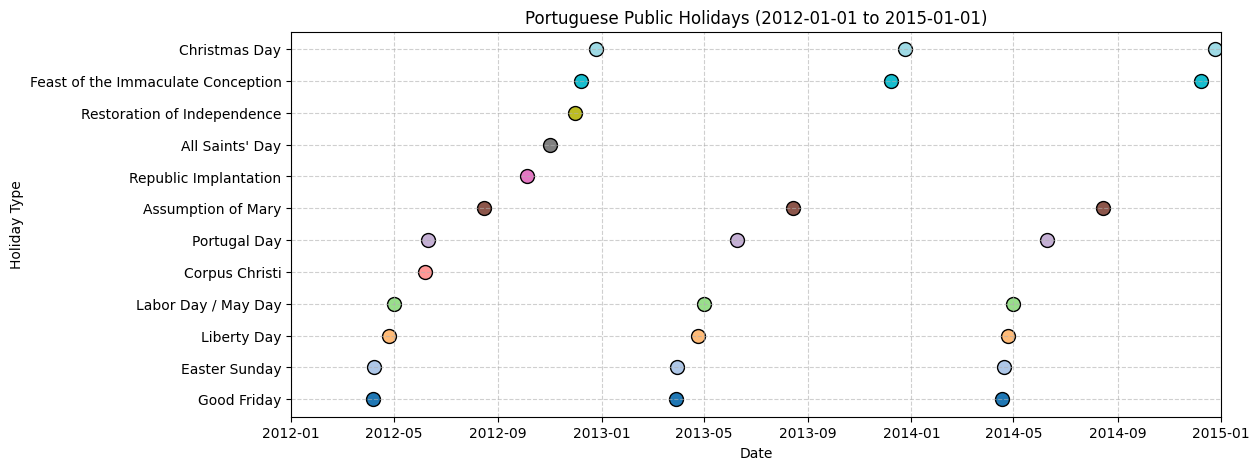

In [51]:
date_range = pd.date_range(start="2012-01-01", end="2015-01-01")

fig, ax = plt.subplots(figsize=(12, 5))

holiday_types = portuguese_holidays.unique()
colormap = plt.colormaps["tab20"]
colors = colormap(np.linspace(0, 1, len(holiday_types)))
color_map = dict(zip(holiday_types, colors))

# Plot each holiday type
for holiday, color in color_map.items():
    subset = portuguese_holidays[portuguese_holidays == holiday]
    ax.scatter(subset.index, [holiday] * len(subset), color=color, label=holiday, s=100, edgecolors="black")

# Formatting the plot
ax.set_xlim(pd.Timestamp("2012-01-01"), pd.Timestamp("2015-01-01"))  # Ensure full range
plt.xlabel("Date")
plt.ylabel("Holiday Type")
plt.title("Portuguese Public Holidays (2012-01-01 to 2015-01-01)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

In [54]:
SAVE_PATH = 'dataset/public_holidays/public_holidays.parquet'

portuguese_holidays.to_frame().to_parquet(SAVE_PATH)

pd.read_parquet(SAVE_PATH)

,Name
Date,
2012-04-06,Good Friday
2012-04-08,Easter Sunday
2012-04-25,Liberty Day
2012-05-01,Labor Day / May Day
2012-06-07,Corpus Christi
2012-06-10,Portugal Day
2012-08-15,Assumption of Mary
2012-10-05,Republic Implantation
2012-11-01,All Saints' Day


## Electricity price

In [70]:
# Dataset metadata: https://ec.europa.eu/eurostat/cache/metadata/en/nrg_pc_204_sims.htm
ELECTRICITY_URL = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/nrg_pc_204/?format=SDMX-CSV&lang=en&label=label_only'

electricity_prices_df = pd.read_csv(ELECTRICITY_URL)
electricity_prices_df.head()

,DATAFLOW,LAST UPDATE,freq,product,nrg_cons,unit,tax,currency,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:NRG_PC_204(1.0),19/12/24 23:00:00,"Half-yearly, semesterly",Electrical energy,Consumption from 1 000 kWh to 2 499 kWh - band DB,Kilowatt-hour,All taxes and levies included,Euro,Albania,2011-S1,0.1152,NaN,NaN
1,ESTAT:NRG_PC_204(1.0),19/12/24 23:00:00,"Half-yearly, semesterly",Electrical energy,Consumption from 1 000 kWh to 2 499 kWh - band DB,Kilowatt-hour,All taxes and levies included,Euro,Albania,2011-S2,0.1157,NaN,NaN
2,ESTAT:NRG_PC_204(1.0),19/12/24 23:00:00,"Half-yearly, semesterly",Electrical energy,Consumption from 1 000 kWh to 2 499 kWh - band DB,Kilowatt-hour,All taxes and levies included,Euro,Albania,2012-S1,0.1163,NaN,NaN
3,ESTAT:NRG_PC_204(1.0),19/12/24 23:00:00,"Half-yearly, semesterly",Electrical energy,Consumption from 1 000 kWh to 2 499 kWh - band DB,Kilowatt-hour,All taxes and levies included,Euro,Albania,2012-S2,0.1167,NaN,NaN
4,ESTAT:NRG_PC_204(1.0),19/12/24 23:00:00,"Half-yearly, semesterly",Electrical energy,Consumption from 1 000 kWh to 2 499 kWh - band DB,Kilowatt-hour,All taxes and levies included,Euro,Albania,2013-S1,0.1156,NaN,NaN


In [72]:
electricity_prices_df.query(f"geo == 'Portugal'")['nrg_cons'].unique()

array(['Consumption from 1 000 kWh to 2 499 kWh - band DB',
       'Consumption from 2 500 kWh to 4 999 kWh - band DC',
       'Consumption from 5 000 kWh to 14 999 kWh - band DD',
       'Consumption for 15 000 kWh or over - band DE',
       'Consumption less than 1 000 kWh - band DA',
       'Consumption of kWh - all bands'], dtype=object)

In [73]:
electricity_prices_df.query(f"geo == 'Portugal'")['unit'].unique()

array(['Kilowatt-hour'], dtype=object)

In [74]:
electricity_prices_df.query(f"geo == 'Portugal'")['tax'].unique()

array(['All taxes and levies included', 'Excluding taxes and levies',
       'Excluding VAT and other recoverable taxes and levies'],
      dtype=object)

In [83]:
electricity_prices_df.query(f"geo == 'Portugal'")['TIME_PERIOD'].unique()

array(['2007-S2', '2008-S1', '2008-S2', '2009-S1', '2009-S2', '2010-S1',
       '2010-S2', '2011-S1', '2011-S2', '2012-S1', '2012-S2', '2013-S1',
       '2013-S2', '2014-S1', '2014-S2', '2015-S1', '2015-S2', '2016-S1',
       '2016-S2', '2017-S1', '2017-S2', '2018-S1', '2018-S2', '2019-S1',
       '2019-S2', '2020-S1', '2020-S2', '2021-S1', '2021-S2', '2022-S1',
       '2022-S2', '2023-S1', '2023-S2', '2024-S1'], dtype=object)

In [91]:
electricity_prices_df.query(f"geo == 'Portugal'")['product'].unique()

array(['Electrical energy'], dtype=object)

In [86]:
def semester_to_date(sem):
    year, semester = sem.split("-")
    month = "01" if semester == "S1" else "07"
    return pd.to_datetime(f"{year}-{month}-01")

electricity_prices_df['date'] = electricity_prices_df['TIME_PERIOD'].apply(semester_to_date)

electricity_prices_df['date']

0       2011-01-01
1       2011-07-01
2       2012-01-01
3       2012-07-01
4       2013-01-01
           ...    
59020   2021-07-01
59021   2022-01-01
59022   2022-07-01
59023   2023-07-01
59024   2024-01-01
Name: date, Length: 59025, dtype: datetime64[ns]

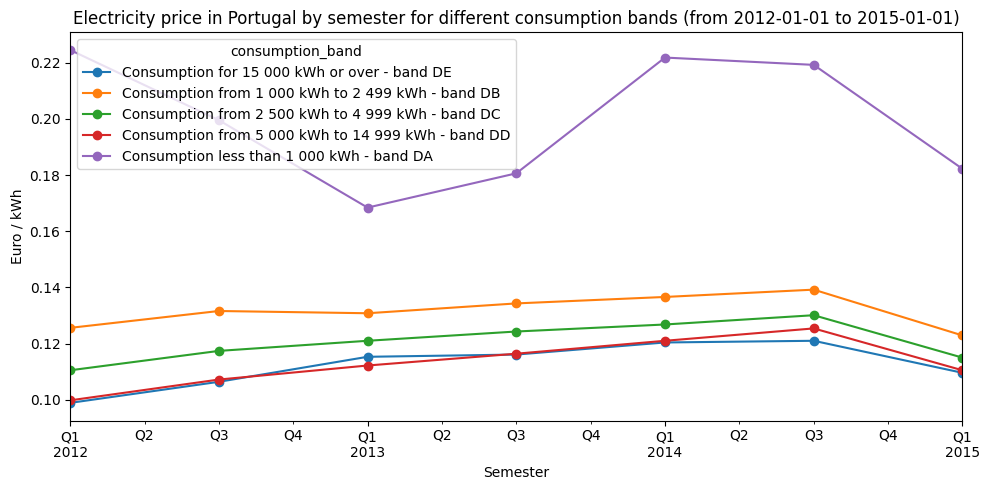

In [108]:
portugal_mask = electricity_prices_df['geo'] == 'Portugal'
start_date_mask = electricity_prices_df['date'] >= pd.to_datetime('2012-01-01')
end_date_mask = electricity_prices_df['date'] <= pd.to_datetime('2015-01-01')
tax_mask = electricity_prices_df['tax'] == 'Excluding taxes and levies'
currency_max = electricity_prices_df['currency'] == 'Euro'

combined_mask = portugal_mask & start_date_mask & end_date_mask & tax_mask & currency_max

portguese_electricity_prices = electricity_prices_df[combined_mask][['date', 'nrg_cons', 'OBS_VALUE']]
portguese_electricity_prices = portguese_electricity_prices.rename(columns={'nrg_cons': 'consumption_band', 'OBS_VALUE': 'euro_per_kwh'})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

portguese_electricity_prices.pivot(index='date', columns='consumption_band', values='euro_per_kwh').plot(ax=ax, marker='o')

ax.set_title('Electricity price in Portugal by semester for different consumption bands (from 2012-01-01 to 2015-01-01)')
ax.set_xlabel('Semester')
ax.set_ylabel('Euro / kWh')

plt.tight_layout()
plt.show()

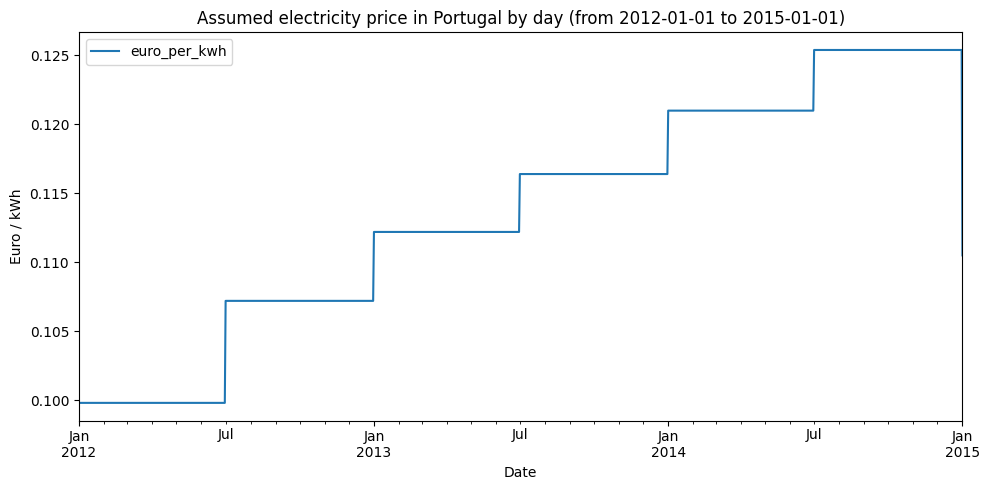

In [126]:
semester_portuguese_electricity_prices_df = portguese_electricity_prices.query("consumption_band == 'Consumption from 5 000 kWh to 14 999 kWh - band DD'")
semester_portuguese_electricity_prices_df = semester_portuguese_electricity_prices_df.drop(columns=['consumption_band'])
semester_portuguese_electricity_prices_df = semester_portuguese_electricity_prices_df.set_index('date')

daily_portuguese_electricity_prices_df = semester_portuguese_electricity_prices_df.resample('D').mean().ffill()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

daily_portuguese_electricity_prices_df.plot(ax=ax)

ax.set_title('Assumed electricity price in Portugal by day (from 2012-01-01 to 2015-01-01)')
ax.set_xlabel('Date')
ax.set_ylabel('Euro / kWh')

plt.tight_layout()
plt.show()

In [130]:
SAVE_PATH = 'dataset/electricity_price/electricity_price.parquet'
daily_portuguese_electricity_prices_df.to_parquet(SAVE_PATH)

pd.read_parquet(SAVE_PATH)

,euro_per_kwh
date,
2012-01-01,0.0998
2012-01-02,0.0998
2012-01-03,0.0998
2012-01-04,0.0998
2012-01-05,0.0998
...,...
2014-12-28,0.1254
2014-12-29,0.1254
2014-12-30,0.1254
